In [1]:
from DETR_model import DinoDetrMaskMul
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset_LowMem, DAVIS_Dataset_LowMem, DAVIS_Infer_LowMem
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset
import logging
import json
from MyLoss import deviation_loss, get_edges
from tenLoader import normalize
from tqdm import tqdm

In [17]:
# train_rawset = DAVIS_Rawset_LowMem(is_train=True)
# val_rawset = DAVIS_Rawset_LowMem(is_train=False)

In [25]:
# train_rawset.data_set = train_rawset.data_set[:10]

# train_dataset = DAVIS_Dataset_LowMem(train_rawset)
# train_infer = DAVIS_Infer_LowMem(train_rawset)

# val_rawset.data_set = val_rawset.data_set[:10]
# val_infer = DAVIS_Infer_LowMem(val_rawset)

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)
val_rawset =DAVIS_Rawset(is_train=False)

In [3]:
# load the dataset

train_rawset.data_set = train_rawset.data_set[:10]

train_dataset = DAVIS_Dataset(train_rawset)
train_infer = DAVIS_Infer(train_rawset)


val_rawset.data_set = val_rawset.data_set[:10]

val_infer = DAVIS_Infer(val_rawset)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [5]:
len(train_loader)

205

In [6]:
unshuffle_train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

In [7]:
def total_len_loss(pred_bou: torch.Tensor, max_coord=224) -> torch.Tensor:
    pred_bou = pred_bou / max_coord
    pred_edges = get_edges(pred_bou)
    return pred_edges.mean()

In [8]:
# load the model
one_layer_model = DinoDetrMaskMul(mul_before=True).cuda()

# load the loss function
ras_loss = RasLoss().cuda()

# load the optimizer
one_layer_optimizer = optim.Adam(one_layer_model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/rass/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
) = next(iter(train_loader))
fir_img.shape, fir_sgm.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4, 224, 224]))

In [10]:
one_layer_train_total_loss_dict = {}
one_layer_train_dif_loss_dict = {}
one_layer_train_std_loss_dict = {}
one_layer_train_len_loss_dict = {}
one_layer_train_iou_dict = {}
one_layer_val_iou_dict = {}
one_layer_best_val_iou = 0
one_layer_interval_epochs = 15
one_layer_interval_steps = 3
one_layer_epoch_index = 0

In [11]:
for interval in range(one_layer_interval_steps):
    for e in range(one_layer_interval_epochs):
        one_layer_model.train()
        mean_total_loss = 0
        mean_dif_loss = 0
        mean_std_loss = 0
        mean_len_loss = 0
        for (
            video_idx,
            frame_idx,
            fir_img,
            fir_sgm,
            pre_img,
            pre_sgm,
            cur_img,
            cur_sgm,
        ) in tqdm(train_loader):
            one_layer_optimizer.zero_grad()
            fir_img = fir_img.cuda()
            fir_sgm = fir_sgm.cuda()
            pre_img = pre_img.cuda()
            pre_sgm = pre_sgm.cuda()
            cur_img = cur_img.cuda()
            cur_sgm = cur_sgm.cuda()
            pred_bou = one_layer_model(fir_img, fir_sgm, pre_img, pre_sgm, cur_img)
            dif_loss = ras_loss(pred_bou, cur_sgm)
            std_loss = deviation_loss(pred_bou)
            len_loss = total_len_loss(pred_bou)
            if std_loss < 0.01:
                loss = 0.33 * dif_loss + 0.33 * len_loss
            else:
                loss = 0.33 * dif_loss + 0.33 * std_loss + 0.33 * len_loss
            loss.backward()
            one_layer_optimizer.step()
            mean_total_loss += loss.item()
            mean_dif_loss += dif_loss.item()
            mean_std_loss += std_loss.item()
            mean_len_loss += len_loss.item()
        mean_total_loss /= len(train_loader)
        mean_dif_loss /= len(train_loader)
        mean_std_loss /= len(train_loader)
        mean_len_loss /= len(train_loader)
        one_layer_train_total_loss_dict[one_layer_epoch_index] = mean_total_loss
        one_layer_train_dif_loss_dict[one_layer_epoch_index] = mean_dif_loss
        one_layer_train_std_loss_dict[one_layer_epoch_index] = mean_std_loss
        one_layer_train_len_loss_dict[one_layer_epoch_index] = mean_len_loss
        print(f"Epoch {one_layer_epoch_index}, Dif Loss: {mean_dif_loss}")
        print(f"Epoch {one_layer_epoch_index}, Std Loss: {mean_std_loss}")
        print(f"Epoch {one_layer_epoch_index}, Len Loss: {mean_len_loss}")
        print(f"Epoch {one_layer_epoch_index}, total Loss: {mean_total_loss}")
        one_layer_epoch_index += 1
    train_infer.infer_model(one_layer_model)
    train_iou = train_infer.get_total_iou()
    one_layer_train_iou_dict[one_layer_epoch_index] = train_iou
    val_infer.infer_model(one_layer_model)
    val_iou = val_infer.get_total_iou()
    one_layer_val_iou_dict[one_layer_epoch_index] = val_iou
    print(f"Epoch {one_layer_epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 22.99it/s]


Epoch 0, Dif Loss: 0.6005937442546938
Epoch 0, Std Loss: 0.059177250428715855
Epoch 0, Len Loss: 0.0542855441570282
Epoch 0, total Loss: 0.23563866724328297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.35it/s]


Epoch 1, Dif Loss: 0.47348195517935404
Epoch 1, Std Loss: 0.03676703132961581
Epoch 1, Len Loss: 0.029491836341415962
Epoch 1, total Loss: 0.1780555323129747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.40it/s]


Epoch 2, Dif Loss: 0.4171663636114539
Epoch 2, Std Loss: 0.029583239598517736
Epoch 2, Len Loss: 0.026401072808700365
Epoch 2, total Loss: 0.15595737553951217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.41it/s]


Epoch 3, Dif Loss: 0.40915403685918666
Epoch 3, Std Loss: 0.026911438613130553
Epoch 3, Len Loss: 0.023718466055465907
Epoch 3, total Loss: 0.15147349939840596


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.42it/s]


Epoch 4, Dif Loss: 0.3888375006070951
Epoch 4, Std Loss: 0.024881540515982525
Epoch 4, Len Loss: 0.02168516307705786
Epoch 4, total Loss: 0.14353513844856403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.43it/s]


Epoch 5, Dif Loss: 0.3776031055101534
Epoch 5, Std Loss: 0.02315118215160399
Epoch 5, Len Loss: 0.020308962246266805
Epoch 5, total Loss: 0.13878556206458953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.45it/s]


Epoch 6, Dif Loss: 0.37891968692221295
Epoch 6, Std Loss: 0.022422175761312245
Epoch 6, Len Loss: 0.019415215348325125
Epoch 6, total Loss: 0.1386710219630381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.43it/s]


Epoch 7, Dif Loss: 0.3629085854786198
Epoch 7, Std Loss: 0.021048057917505504
Epoch 7, Len Loss: 0.018012625662746227
Epoch 7, total Loss: 0.1324011846468216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 22.55it/s]


Epoch 8, Dif Loss: 0.3475439397300162
Epoch 8, Std Loss: 0.019957185541166038
Epoch 8, Len Loss: 0.01686405037734203
Epoch 8, total Loss: 0.12651660438717865


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.89it/s]


Epoch 9, Dif Loss: 0.3708260294867725
Epoch 9, Std Loss: 0.01852269552523134
Epoch 9, Len Loss: 0.015168096870183945
Epoch 9, total Loss: 0.13314377209398803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.90it/s]


Epoch 10, Dif Loss: 0.34277875772336636
Epoch 10, Std Loss: 0.01806124708183655
Epoch 10, Len Loss: 0.014049461815029201
Epoch 10, total Loss: 0.12341186153452571


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 21.80it/s]


Epoch 11, Dif Loss: 0.33319940654242913
Epoch 11, Std Loss: 0.01776974745401431
Epoch 11, Len Loss: 0.013575513779594586
Epoch 11, total Loss: 0.11986295872526925


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 23.70it/s]


Epoch 12, Dif Loss: 0.3410897385783312
Epoch 12, Std Loss: 0.01716983173107842
Epoch 12, Len Loss: 0.013107587659458925
Epoch 12, total Loss: 0.12206958708603208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.75it/s]


Epoch 13, Dif Loss: 0.3416521470721175
Epoch 13, Std Loss: 0.016952951004864967
Epoch 13, Len Loss: 0.012751409460835885
Epoch 13, total Loss: 0.1221052807460471


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.79it/s]


Epoch 14, Dif Loss: 0.3511201684067889
Epoch 14, Std Loss: 0.016731749172180482
Epoch 14, Len Loss: 0.012397488514699679
Epoch 14, total Loss: 0.1249889109556268
Epoch 15, Train IoU: 0.38667135403231456, Val IoU: 0.14096922117719224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.68it/s]


Epoch 15, Dif Loss: 0.35176582569029274
Epoch 15, Std Loss: 0.016425024216324545
Epoch 15, Len Loss: 0.012186106639948287
Epoch 15, total Loss: 0.12499952865083043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.74it/s]


Epoch 16, Dif Loss: 0.32889239817130855
Epoch 16, Std Loss: 0.016516317564585225
Epoch 16, Len Loss: 0.012133305631407605
Epoch 16, total Loss: 0.11741752869835714


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.71it/s]


Epoch 17, Dif Loss: 0.3490421879582289
Epoch 17, Std Loss: 0.016470736024685476
Epoch 17, Len Loss: 0.012035261310364415
Epoch 17, total Loss: 0.12415208645710131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.69it/s]


Epoch 18, Dif Loss: 0.33318280243292087
Epoch 18, Std Loss: 0.01623222260514456
Epoch 18, Len Loss: 0.011835669043825985
Epoch 18, total Loss: 0.11863584920037083


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.70it/s]


Epoch 19, Dif Loss: 0.3458295740732333
Epoch 19, Std Loss: 0.01648362437476086
Epoch 19, Len Loss: 0.011740721935383612
Epoch 19, total Loss: 0.1229180473561694


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.70it/s]


Epoch 20, Dif Loss: 0.3252455094965493
Epoch 20, Std Loss: 0.01610156608839156
Epoch 20, Len Loss: 0.011502255489141112
Epoch 20, total Loss: 0.11576589792966843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.74it/s]


Epoch 21, Dif Loss: 0.32023875219065967
Epoch 21, Std Loss: 0.01626631060399388
Epoch 21, Len Loss: 0.01154376349849172
Epoch 21, total Loss: 0.11425193339222815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.73it/s]


Epoch 22, Dif Loss: 0.3344829992550175
Epoch 22, Std Loss: 0.015877395710998738
Epoch 22, Len Loss: 0.011417956716415087
Epoch 22, total Loss: 0.11891233374069377


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.72it/s]


Epoch 23, Dif Loss: 0.3330483959942329
Epoch 23, Std Loss: 0.01585850233053107
Epoch 23, Len Loss: 0.01135479831250339
Epoch 23, total Loss: 0.11822299132259881


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.71it/s]


Epoch 24, Dif Loss: 0.3204202808984896
Epoch 24, Std Loss: 0.015797647464986346
Epoch 24, Len Loss: 0.011344773001775782
Epoch 24, total Loss: 0.11409746755550547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.71it/s]


Epoch 25, Dif Loss: 0.34350408868091864
Epoch 25, Std Loss: 0.016168333078087193
Epoch 25, Len Loss: 0.011341760584959623
Epoch 25, total Loss: 0.12190064164560016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.71it/s]


Epoch 26, Dif Loss: 0.32074917903760586
Epoch 26, Std Loss: 0.015623196677543314
Epoch 26, Len Loss: 0.011168963087029846
Epoch 26, total Loss: 0.11418505485464887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.72it/s]


Epoch 27, Dif Loss: 0.32982921687568106
Epoch 27, Std Loss: 0.015663453024420206
Epoch 27, Len Loss: 0.011166532437896311
Epoch 27, total Loss: 0.11714405753627057


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.76it/s]


Epoch 28, Dif Loss: 0.3155187705668007
Epoch 28, Std Loss: 0.015626983550411262
Epoch 28, Len Loss: 0.011204313990239781
Epoch 28, total Loss: 0.11227895473925079


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.75it/s]


Epoch 29, Dif Loss: 0.3284644100724197
Epoch 29, Std Loss: 0.015488739448696057
Epoch 29, Len Loss: 0.011168174785505072
Epoch 29, total Loss: 0.11656655033187169
Epoch 30, Train IoU: 0.4007688220192199, Val IoU: 0.17281027716209704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.71it/s]


Epoch 30, Dif Loss: 0.33714684480574075
Epoch 30, Std Loss: 0.015451441833425722
Epoch 30, Len Loss: 0.011024922163157565
Epoch 30, total Loss: 0.11950463678051786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.76it/s]


Epoch 31, Dif Loss: 0.30583502926477574
Epoch 31, Std Loss: 0.015540047569438905
Epoch 31, Len Loss: 0.011000393704431722
Epoch 31, total Loss: 0.1091262462844209


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.75it/s]


Epoch 32, Dif Loss: 0.32752803534996217
Epoch 32, Std Loss: 0.01536066247201411
Epoch 32, Len Loss: 0.011034352336044809
Epoch 32, total Loss: 0.11620697191939121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.75it/s]


Epoch 33, Dif Loss: 0.3405728691961707
Epoch 33, Std Loss: 0.015283934667950678
Epoch 33, Len Loss: 0.010960835737755477
Epoch 33, total Loss: 0.12046947070374721


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.73it/s]


Epoch 34, Dif Loss: 0.29601734934783563
Epoch 34, Std Loss: 0.015444369633148266
Epoch 34, Len Loss: 0.010963128354093741
Epoch 34, total Loss: 0.10573324764647135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.75it/s]


Epoch 35, Dif Loss: 0.32252966630749585
Epoch 35, Std Loss: 0.015488922707566128
Epoch 35, Len Loss: 0.011074107434464301
Epoch 35, total Loss: 0.11460512011516386


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.73it/s]


Epoch 36, Dif Loss: 0.32733929040955334
Epoch 36, Std Loss: 0.015264334565698647
Epoch 36, Len Loss: 0.010963617131204867
Epoch 36, total Loss: 0.11601306392652233


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 24.08it/s]


Epoch 37, Dif Loss: 0.3325834945934575
Epoch 37, Std Loss: 0.015356497228054738
Epoch 37, Len Loss: 0.010909760370282684
Epoch 37, total Loss: 0.11781162550536597


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.84it/s]


Epoch 38, Dif Loss: 0.30975834509221517
Epoch 38, Std Loss: 0.015221143434982655
Epoch 38, Len Loss: 0.010842516807634837
Epoch 38, total Loss: 0.11017845189426004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.85it/s]


Epoch 39, Dif Loss: 0.3206925165362474
Epoch 39, Std Loss: 0.015364220095855162
Epoch 39, Len Loss: 0.010819769340067557
Epoch 39, total Loss: 0.11392495686688074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.86it/s]


Epoch 40, Dif Loss: 0.31914933629152253
Epoch 40, Std Loss: 0.015312453696118077
Epoch 40, Len Loss: 0.010762913323507258
Epoch 40, total Loss: 0.11322512770207917


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.88it/s]


Epoch 41, Dif Loss: 0.3378364664752309
Epoch 41, Std Loss: 0.015226637601579834
Epoch 41, Len Loss: 0.010767590117970164
Epoch 41, total Loss: 0.11946356872596392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.86it/s]


Epoch 42, Dif Loss: 0.32589384375548947
Epoch 42, Std Loss: 0.01521820910942241
Epoch 42, Len Loss: 0.010818278525740181
Epoch 42, total Loss: 0.1155627607390648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.85it/s]


Epoch 43, Dif Loss: 0.29991774297342066
Epoch 43, Std Loss: 0.015219296815396265
Epoch 43, Len Loss: 0.010823352013930405
Epoch 43, total Loss: 0.10695863751376547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:09<00:00, 20.87it/s]


Epoch 44, Dif Loss: 0.3188956914878473
Epoch 44, Std Loss: 0.01517810912351351
Epoch 44, Len Loss: 0.010900396234128714
Epoch 44, total Loss: 0.11323649118222841
Epoch 45, Train IoU: 0.3921183594388655, Val IoU: 0.21317587863621434


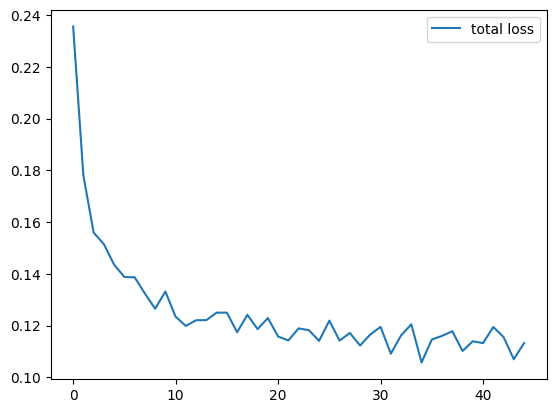

In [12]:
# plot the loss
plt.plot(list(one_layer_train_total_loss_dict.keys()), list(one_layer_train_total_loss_dict.values()), label="total loss")
# plt.plot(list(one_layer_train_dif_loss_dict.keys()), list(one_layer_train_dif_loss_dict.values()), label="dif loss")
# plt.plot(list(one_layer_train_std_loss_dict.keys()), list(one_layer_train_std_loss_dict.values()), label="std loss")
# plt.plot(list(one_layer_train_len_loss_dict.keys()), list(one_layer_train_len_loss_dict.values()), label="len loss")
# # plt the iou

plt.legend()

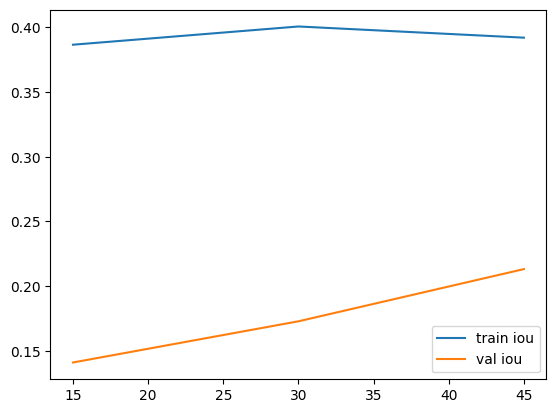

In [13]:
plt.plot(list(one_layer_train_iou_dict.keys()), list(one_layer_train_iou_dict.values()), label="train iou")
plt.plot(list(one_layer_val_iou_dict.keys()), list(one_layer_val_iou_dict.values()), label="val iou")
plt.legend()

In [14]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
) = next(iter(unshuffle_train_loader))
fir_img.shape, fir_sgm.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4, 224, 224]))

In [15]:
pred_bou = one_layer_model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
pred_bou.shape

torch.Size([4, 80, 2])

In [16]:
sharpness = 0.1
soft_polygon = SoftPolygon(inv_smoothness=sharpness)
pred_mask = soft_polygon(pred_bou, 224, 224)
pred_mask.shape

torch.Size([4, 224, 224])

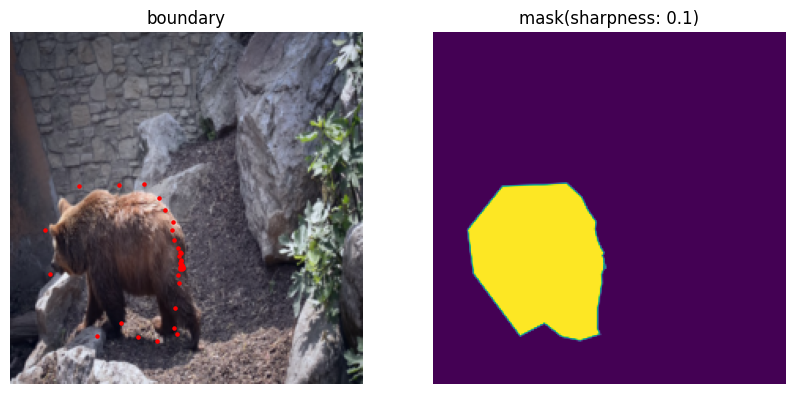

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(
    normalize(
        cur_img[0].permute(1, 2, 0).cpu().detach().numpy(),
    ),
)
plt.axis("off")
# plt.plot(
#     pred_bou[0, :, 0].cpu().detach().numpy(),
#     pred_bou[0, :, 1].cpu().detach().numpy(),
#     "r",
#     linewidth=20,
# )
plt.scatter(
    pred_bou[0, :, 0].cpu().detach().numpy(),
    pred_bou[0, :, 1].cpu().detach().numpy(),
    c="r",
    s=5,
)
plt.title("boundary")
plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0].cpu().detach().numpy())
plt.axis("off")
plt.title(f"mask(sharpness: {sharpness})")
plt.show()

In [18]:
# load the model
model = DinoDetrMaskMul(mul_before=True, nhead=6, num_layers=6).cuda()

# load the loss function
ras_loss = RasLoss(inv_smoothness=1000.0).cuda()

# load the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [19]:
train_total_loss_dict = {}
train_dif_loss_dict = {}
train_std_loss_dict = {}
train_len_loss_dict = {}
train_iou_dict = {}
val_iou_dict = {}
best_val_iou = 0
interval_epochs = 15
interval_steps = 3
epoch_index = 0

In [20]:
for interval in range(interval_steps):
    for e in range(interval_epochs):
        model.train()
        mean_total_loss = 0
        mean_dif_loss = 0
        mean_std_loss = 0
        mean_len_loss = 0
        for (
            video_idx,
            frame_idx,
            fir_img,
            fir_sgm,
            pre_img,
            pre_sgm,
            cur_img,
            cur_sgm,
        ) in tqdm(train_loader):
            optimizer.zero_grad()
            fir_img = fir_img.cuda()
            fir_sgm = fir_sgm.cuda()
            pre_img = pre_img.cuda()
            pre_sgm = pre_sgm.cuda()
            cur_img = cur_img.cuda()
            cur_sgm = cur_sgm.cuda()
            pred_bou = model(fir_img, fir_sgm, pre_img, pre_sgm, cur_img)
            dif_loss = ras_loss(pred_bou, cur_sgm)
            std_loss = deviation_loss(pred_bou)
            len_loss = total_len_loss(pred_bou)
            if std_loss < 0.01 and len_loss >= 0.01:
                loss = 0.33 * dif_loss + 0.33 * len_loss
            elif std_loss >= 0.01 and len_loss < 0.01:
                loss = 0.33 * dif_loss + 0.33 * std_loss
            elif std_loss < 0.01 and len_loss < 0.01:
                loss = 0.33 * dif_loss
            else:
                loss = 0.33 * dif_loss + 0.33 * std_loss + 0.33 * len_loss
            loss.backward()
            optimizer.step()
            mean_total_loss += loss.item()
            mean_dif_loss += dif_loss.item()
            mean_std_loss += std_loss.item()
            mean_len_loss += len_loss.item()
        mean_total_loss /= len(train_loader)
        mean_dif_loss /= len(train_loader)
        mean_std_loss /= len(train_loader)
        mean_len_loss /= len(train_loader)
        train_total_loss_dict[epoch_index] = mean_total_loss
        train_dif_loss_dict[epoch_index] = mean_dif_loss
        train_std_loss_dict[epoch_index] = mean_std_loss
        train_len_loss_dict[epoch_index] = mean_len_loss
        print(f"Epoch {epoch_index}, Dif Loss: {mean_dif_loss}")
        print(f"Epoch {epoch_index}, Std Loss: {mean_std_loss}")
        print(f"Epoch {epoch_index}, Len Loss: {mean_len_loss}")
        print(f"Epoch {epoch_index}, total Loss: {mean_total_loss}")
        epoch_index += 1
    train_infer.infer_model(model)
    train_iou = train_infer.get_total_iou()
    train_iou_dict[epoch_index] = train_iou
    val_infer.infer_model(model)
    val_iou = val_infer.get_total_iou()
    val_iou_dict[epoch_index] = val_iou
    print(f"Epoch {epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")

  0%|                                                                                                                                           | 0/205 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.69it/s]


Epoch 0, Dif Loss: 0.9986608740760059
Epoch 0, Std Loss: 0.0012733874217856949
Epoch 0, Len Loss: 0.0020765179174770487
Epoch 0, total Loss: 0.33000021809484903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.74it/s]


Epoch 1, Dif Loss: 0.9999095335239317
Epoch 1, Std Loss: 0.00034338285629751113
Epoch 1, Len Loss: 0.000622021031378564
Epoch 1, total Loss: 0.32997015860022566


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.83it/s]


Epoch 2, Dif Loss: 0.9999112161194406
Epoch 2, Std Loss: 0.00018429456515771495
Epoch 2, Len Loss: 0.0003436159573938334
Epoch 2, total Loss: 0.32997071437719394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.85it/s]


Epoch 3, Dif Loss: 0.9999120409895734
Epoch 3, Std Loss: 0.00011566144044414481
Epoch 3, Len Loss: 0.00021487054615224735
Epoch 3, total Loss: 0.3299709866686565


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.83it/s]


Epoch 4, Dif Loss: 0.9999121273436198
Epoch 4, Std Loss: 8.73837530223948e-05
Epoch 4, Len Loss: 0.0001608135907700649
Epoch 4, total Loss: 0.329971014144944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.83it/s]


Epoch 5, Dif Loss: 0.9999096434290816
Epoch 5, Std Loss: 7.721289148321375e-05
Epoch 5, Len Loss: 0.00014019667351243607
Epoch 5, total Loss: 0.3299701947991441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.78it/s]


Epoch 6, Dif Loss: 0.9999109675244587
Epoch 6, Std Loss: 6.855788565078955e-05
Epoch 6, Len Loss: 0.00012417700054356828
Epoch 6, total Loss: 0.32997063136682275


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.76it/s]


Epoch 7, Dif Loss: 0.9999107436435979
Epoch 7, Std Loss: 6.525193989878839e-05
Epoch 7, Len Loss: 0.00011759307721726279
Epoch 7, total Loss: 0.3299705585328544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.78it/s]


Epoch 8, Dif Loss: 0.999909843758839
Epoch 8, Std Loss: 6.295048813449173e-05
Epoch 8, Len Loss: 0.00011289696608068104
Epoch 8, total Loss: 0.32997026123651646


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.76it/s]


Epoch 9, Dif Loss: 0.9999119546355271
Epoch 9, Std Loss: 6.28471164928647e-05
Epoch 9, Len Loss: 0.00011186433136860681
Epoch 9, total Loss: 0.3299709577385972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.76it/s]


Epoch 10, Dif Loss: 0.9999074063649992
Epoch 10, Std Loss: 6.230499049884312e-05
Epoch 10, Len Loss: 0.00011001020920514015
Epoch 10, total Loss: 0.32996945686456636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.76it/s]


Epoch 11, Dif Loss: 0.9999095710312448
Epoch 11, Std Loss: 6.0604506817493e-05
Epoch 11, Len Loss: 0.00010795926493478985
Epoch 11, total Loss: 0.32997017066653184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.76it/s]


Epoch 12, Dif Loss: 0.9999080073542711
Epoch 12, Std Loss: 6.0414072238306355e-05
Epoch 12, Len Loss: 0.00010678793194351672
Epoch 12, total Loss: 0.3299696539960256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.76it/s]


Epoch 13, Dif Loss: 0.9999112911340667
Epoch 13, Std Loss: 5.8676429549317304e-05
Epoch 13, Len Loss: 0.00010459606579033568
Epoch 13, total Loss: 0.3299707390913149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.70it/s]


Epoch 14, Dif Loss: 0.9999110224770337
Epoch 14, Std Loss: 5.8897245066984354e-05
Epoch 14, Len Loss: 0.00010440403665841853
Epoch 14, total Loss: 0.32997064881208465
Epoch 15, Train IoU: 0.06435401653919402, Val IoU: 0.014495009821096777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 15, Dif Loss: 0.9999119799311568
Epoch 15, Std Loss: 5.817144167561243e-05
Epoch 15, Len Loss: 0.00010287386866388616
Epoch 15, total Loss: 0.32997096573434226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.87it/s]


Epoch 16, Dif Loss: 0.9999069263295429
Epoch 16, Std Loss: 5.680820437946084e-05
Epoch 16, Len Loss: 0.00010195256472798065
Epoch 16, total Loss: 0.32996929753117443


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.85it/s]


Epoch 17, Dif Loss: 0.9999104595765835
Epoch 17, Std Loss: 5.6651489143316614e-05
Epoch 17, Len Loss: 0.00010009645534077341
Epoch 17, total Loss: 0.32997046432844024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.85it/s]


Epoch 18, Dif Loss: 0.9999099786688642
Epoch 18, Std Loss: 5.510145851209328e-05
Epoch 18, Len Loss: 9.858599685064358e-05
Epoch 18, total Loss: 0.32997030557655704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 19, Dif Loss: 0.9999094291431148
Epoch 19, Std Loss: 5.597391855411754e-05
Epoch 19, Len Loss: 9.891012890786842e-05
Epoch 19, total Loss: 0.3299701237097019


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 20, Dif Loss: 0.9999113187557314
Epoch 20, Std Loss: 5.436490796344559e-05
Epoch 20, Len Loss: 9.671628695952411e-05
Epoch 20, total Loss: 0.32997074810470023


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 21, Dif Loss: 0.9999081890757491
Epoch 21, Std Loss: 5.394053423958944e-05
Epoch 21, Len Loss: 9.560879605975593e-05
Epoch 21, total Loss: 0.3299697144729335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.83it/s]


Epoch 22, Dif Loss: 0.999911103306747
Epoch 22, Std Loss: 5.302473541743849e-05
Epoch 22, Len Loss: 9.46915430576177e-05
Epoch 22, total Loss: 0.3299706771606352


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.83it/s]


Epoch 23, Dif Loss: 0.9999113745805693
Epoch 23, Std Loss: 5.264739177996157e-05
Epoch 23, Len Loss: 9.385941900801277e-05
Epoch 23, total Loss: 0.32997076613147086


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.71it/s]


Epoch 24, Dif Loss: 0.9999101377115017
Epoch 24, Std Loss: 5.216697765451788e-05
Epoch 24, Len Loss: 9.269343079323312e-05
Epoch 24, total Loss: 0.3299703576215884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.61it/s]


Epoch 25, Dif Loss: 0.9999110437021023
Epoch 25, Std Loss: 5.080130777503477e-05
Epoch 25, Len Loss: 9.10307522423043e-05
Epoch 25, total Loss: 0.3299706569532069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.62it/s]


Epoch 26, Dif Loss: 0.9999097329814259
Epoch 26, Std Loss: 4.9896572507838376e-05
Epoch 26, Len Loss: 8.91373103424884e-05
Epoch 26, total Loss: 0.3299702247468437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.60it/s]


Epoch 27, Dif Loss: 0.999911296949154
Epoch 27, Std Loss: 4.945834371028468e-05
Epoch 27, Len Loss: 8.825750779445715e-05
Epoch 27, total Loss: 0.32997074054508674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.61it/s]


Epoch 28, Dif Loss: 0.9999107238723011
Epoch 28, Std Loss: 4.8396881867097916e-05
Epoch 28, Len Loss: 8.67000327405815e-05
Epoch 28, total Loss: 0.329970551845504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.63it/s]


Epoch 29, Dif Loss: 0.9999102528502302
Epoch 29, Std Loss: 4.869722888986694e-05
Epoch 29, Len Loss: 8.618898420713888e-05
Epoch 29, total Loss: 0.3299703967280504
Epoch 30, Train IoU: 0.06435401653919402, Val IoU: 0.014495009821096777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.59it/s]


Epoch 30, Dif Loss: 0.9999080486413909
Epoch 30, Std Loss: 4.6519299886734565e-05
Epoch 30, Len Loss: 8.335065046217428e-05
Epoch 30, total Loss: 0.32996966809761236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.62it/s]


Epoch 31, Dif Loss: 0.9999081003956678
Epoch 31, Std Loss: 4.591923838810677e-05
Epoch 31, Len Loss: 8.232026352410819e-05
Epoch 31, total Loss: 0.32996968612438293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.59it/s]


Epoch 32, Dif Loss: 0.9999124230408087
Epoch 32, Std Loss: 4.515595987535695e-05
Epoch 32, Len Loss: 8.053161081767119e-05
Epoch 32, total Loss: 0.32997111256529643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.61it/s]


Epoch 33, Dif Loss: 0.9999103150716642
Epoch 33, Std Loss: 4.3734882993015983e-05
Epoch 33, Len Loss: 7.848782750931228e-05
Epoch 33, total Loss: 0.3299704156270841


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.57it/s]


Epoch 34, Dif Loss: 0.9999082536232181
Epoch 34, Std Loss: 4.29695882769188e-05
Epoch 34, Len Loss: 7.684131411313102e-05
Epoch 34, total Loss: 0.3299697375879055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.54it/s]


Epoch 35, Dif Loss: 0.999911096037888
Epoch 35, Std Loss: 4.1706355841597545e-05
Epoch 35, Len Loss: 7.496716035104061e-05
Epoch 35, total Loss: 0.3299706748346003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.64it/s]


Epoch 36, Dif Loss: 0.9999116906305638
Epoch 36, Std Loss: 4.0927731269465124e-05
Epoch 36, Len Loss: 7.288502085607544e-05
Epoch 36, total Loss: 0.3299708709484193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.60it/s]


Epoch 37, Dif Loss: 0.9999097419948113
Epoch 37, Std Loss: 3.9981854934012516e-05
Epoch 37, Len Loss: 7.130359540829753e-05
Epoch 37, total Loss: 0.3299702277997645


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.60it/s]


Epoch 38, Dif Loss: 0.9999109945646146
Epoch 38, Std Loss: 3.8974074076821395e-05
Epoch 38, Len Loss: 6.941101764379887e-05
Epoch 38, total Loss: 0.3299706400894537


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.60it/s]


Epoch 39, Dif Loss: 0.9999127483949428
Epoch 39, Std Loss: 3.802809381939857e-05
Epoch 39, Len Loss: 6.757567121317928e-05
Epoch 39, total Loss: 0.3299712204351658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.60it/s]


Epoch 40, Dif Loss: 0.9999136712492966
Epoch 40, Std Loss: 3.6811914416342386e-05
Epoch 40, Len Loss: 6.534064262423937e-05
Epoch 40, total Loss: 0.32997152485498565


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.61it/s]


Epoch 41, Dif Loss: 0.999909992043565
Epoch 41, Std Loss: 3.542411671710064e-05
Epoch 41, Len Loss: 6.322347452202472e-05
Epoch 41, total Loss: 0.3299703102286269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.61it/s]


Epoch 42, Dif Loss: 0.9999111783213732
Epoch 42, Std Loss: 3.422773853100541e-05
Epoch 42, Len Loss: 6.084906092771079e-05
Epoch 42, total Loss: 0.3299707020201334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.60it/s]


Epoch 43, Dif Loss: 0.9999075895402489
Epoch 43, Std Loss: 3.2954982097868283e-05
Epoch 43, Len Loss: 5.856293460166809e-05
Epoch 43, total Loss: 0.3299695176322286


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.59it/s]


Epoch 44, Dif Loss: 0.9999107974331554
Epoch 44, Std Loss: 3.162836978955921e-05
Epoch 44, Len Loss: 5.6298825181395994e-05
Epoch 44, total Loss: 0.3299705758327391
Epoch 45, Train IoU: 0.06435401653919402, Val IoU: 0.014495009821096777


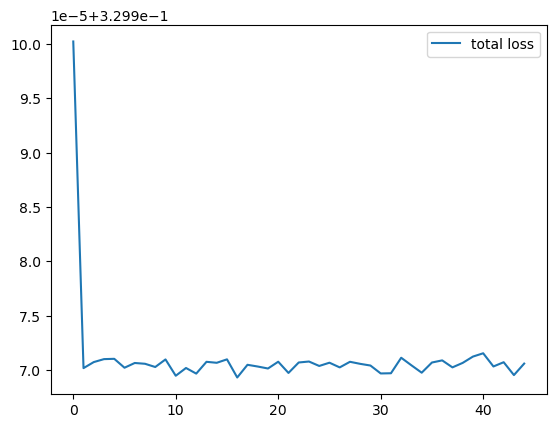

In [21]:
# plot the loss
plt.plot(list(train_total_loss_dict.keys()), list(train_total_loss_dict.values()), label="total loss")

plt.legend()

In [22]:
train_iou_dict.keys()

dict_keys([15, 30, 45])

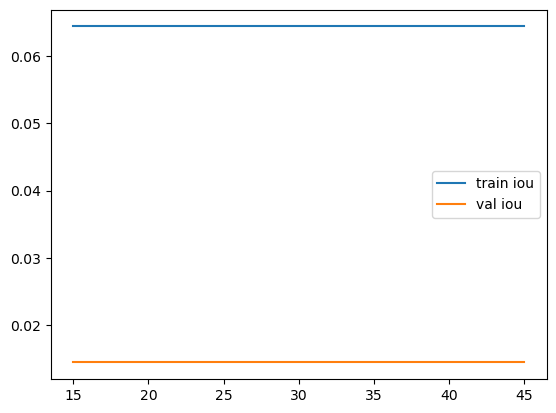

In [23]:
# plot the iou
plt.plot(list(train_iou_dict.keys()), list(train_iou_dict.values()), label="train iou")
plt.plot(list(val_iou_dict.keys()), list(val_iou_dict.values()), label="val iou")
plt.legend()

In [24]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
) = next(iter(unshuffle_train_loader))
fir_img.shape, fir_sgm.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4, 224, 224]))

In [25]:
pred_bou = model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
pred_bou.shape

torch.Size([4, 80, 2])

In [26]:
sharpness = 0.1
soft_polygon = SoftPolygon(inv_smoothness=sharpness)
pred_mask = soft_polygon(pred_bou, 224, 224)
pred_mask.shape

torch.Size([4, 224, 224])

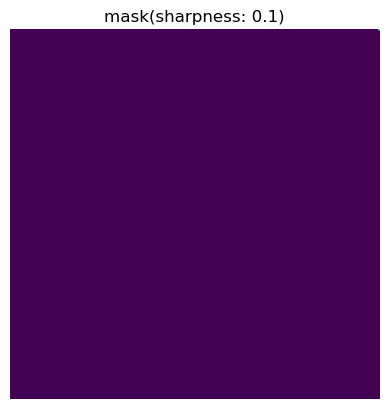

In [27]:
plt.imshow(pred_mask[0].cpu().detach().numpy())
plt.axis("off")
plt.title(f"mask(sharpness: {sharpness})")
plt.show()

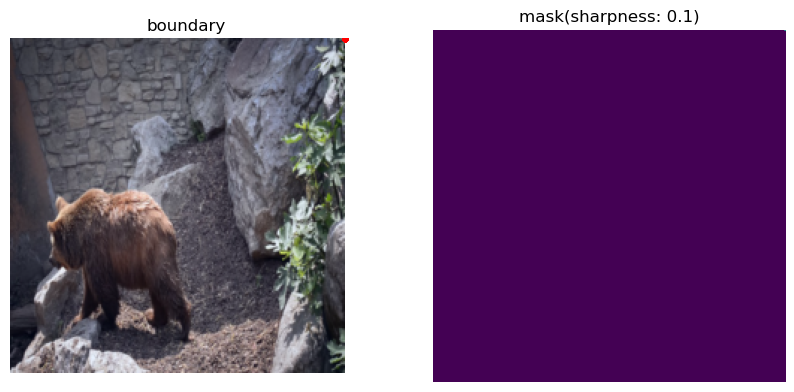

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(
    normalize(
        cur_img[0].permute(1, 2, 0).cpu().detach().numpy(),
    ),
)
plt.axis("off")
# plot the scatter of the boundary
plt.scatter(
    pred_bou[0, :, 0].cpu().detach().numpy(),
    pred_bou[0, :, 1].cpu().detach().numpy(),
    c="r",
    s=10,
)
plt.title("boundary")
plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0].cpu().detach().numpy())
plt.axis("off")
plt.title(f"mask(sharpness: {sharpness})")
plt.show()

In [29]:
new_model = DinoDetrMaskMul(mul_before=True, nhead=6, num_layers=6).cuda()
sharpness = 10000.0
ras_loss = RasLoss(inv_smoothness=sharpness).cuda()
optimizer = optim.Adam(new_model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [30]:
train_total_loss_dict = {}
train_dif_loss_dict = {}
train_std_loss_dict = {}
train_len_loss_dict = {}
train_iou_dict = {}
val_iou_dict = {}
best_val_iou = 0
interval_epochs = 15
interval_steps = 3
epoch_index = 0
sharpness_dict = {}
sharpness_dict[epoch_index] = sharpness

In [31]:
for interval in range(interval_steps):
    for e in range(interval_epochs):
        new_model.train()
        mean_total_loss = 0
        mean_dif_loss = 0
        mean_std_loss = 0
        mean_len_loss = 0
        for (
            video_idx,
            frame_idx,
            fir_img,
            fir_sgm,
            pre_img,
            pre_sgm,
            cur_img,
            cur_sgm,
        ) in tqdm(train_loader):
            optimizer.zero_grad()
            fir_img = fir_img.cuda()
            fir_sgm = fir_sgm.cuda()
            pre_img = pre_img.cuda()
            pre_sgm = pre_sgm.cuda()
            cur_img = cur_img.cuda()
            cur_sgm = cur_sgm.cuda()
            pred_bou = new_model(fir_img, fir_sgm, pre_img, pre_sgm, cur_img)
            dif_loss = ras_loss(pred_bou, cur_sgm)
            std_loss = deviation_loss(pred_bou)
            len_loss = total_len_loss(pred_bou)
            # if std_loss < 0.01 and len_loss >= 0.01:
            #     loss = 0.33 * dif_loss + 0.33 * len_loss
            # elif std_loss >= 0.01 and len_loss < 0.01:
            #     loss = 0.33 * dif_loss + 0.33 * std_loss
            # elif std_loss < 0.01 and len_loss < 0.01:
            #     loss = 0.33 * dif_loss
            # else:
            #     loss = 0.33 * dif_loss + 0.33 * std_loss + 0.33 * len_loss
            loss = 0.33 * dif_loss
            loss.backward()
            optimizer.step()
            mean_total_loss += loss.item()
            mean_dif_loss += dif_loss.item()
            mean_std_loss += std_loss.item()
            mean_len_loss += len_loss.item()
        mean_total_loss /= len(train_loader)
        mean_dif_loss /= len(train_loader)
        mean_std_loss /= len(train_loader)
        mean_len_loss /= len(train_loader)
        train_total_loss_dict[epoch_index] = mean_total_loss
        train_dif_loss_dict[epoch_index] = mean_dif_loss
        train_std_loss_dict[epoch_index] = mean_std_loss
        train_len_loss_dict[epoch_index] = mean_len_loss
        print(f"Epoch {epoch_index}, Dif Loss: {mean_dif_loss}")
        print(f"Epoch {epoch_index}, Std Loss: {mean_std_loss}")
        print(f"Epoch {epoch_index}, Len Loss: {mean_len_loss}")
        print(f"Epoch {epoch_index}, total Loss: {mean_total_loss}")
        epoch_index += 1
        if epoch_index % 1 == 0 and sharpness > 0.1:
            sharpness = sharpness / 2
            if sharpness < 0.1:
                sharpness = 0.1
            ras_loss = RasLoss(inv_smoothness=sharpness).cuda()
            # optimizer = optim.Adam(new_model.parameters(), lr=1e-4)
            sharpness_dict[epoch_index] = sharpness
            print(f"Epoch {epoch_index}, sharpness: {sharpness}")
    train_infer.infer_model(new_model)
    train_iou = train_infer.get_total_iou()
    train_iou_dict[epoch_index] = train_iou
    val_infer.infer_model(new_model)
    val_iou = val_infer.get_total_iou()
    val_iou_dict[epoch_index] = val_iou
    print(f"Epoch {epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")

  0%|                                                                                                                                           | 0/205 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.63it/s]


Epoch 0, Dif Loss: 0.8612340261296528
Epoch 0, Std Loss: 0.01221956584802062
Epoch 0, Len Loss: 0.023225862687956202
Epoch 0, total Loss: 0.2842072399651132
Epoch 1, sharpness: 5000.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.70it/s]


Epoch 1, Dif Loss: 0.861367765577828
Epoch 1, Std Loss: 0.014723082615819293
Epoch 1, Len Loss: 0.02680549801912204
Epoch 1, total Loss: 0.2842513730613197
Epoch 2, sharpness: 2500.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.70it/s]


Epoch 2, Dif Loss: 0.8190691692073171
Epoch 2, Std Loss: 0.01429102204558326
Epoch 2, Len Loss: 0.026347110529498355
Epoch 2, total Loss: 0.27029283693650874
Epoch 3, sharpness: 1250.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.68it/s]


Epoch 3, Dif Loss: 0.8063128075948576
Epoch 3, Std Loss: 0.013517403829751945
Epoch 3, Len Loss: 0.02442716012095533
Epoch 3, total Loss: 0.26608323694729225
Epoch 4, sharpness: 625.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.68it/s]


Epoch 4, Dif Loss: 0.8090944025574661
Epoch 4, Std Loss: 0.016834541446552043
Epoch 4, Len Loss: 0.030140723869567964
Epoch 4, total Loss: 0.2670011636687488
Epoch 5, sharpness: 312.5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.69it/s]


Epoch 5, Dif Loss: 0.8194092567374066
Epoch 5, Std Loss: 0.03717683340172942
Epoch 5, Len Loss: 0.053214033002533564
Epoch 5, total Loss: 0.2704050647049415
Epoch 6, sharpness: 156.25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.70it/s]


Epoch 6, Dif Loss: 0.805290214317601
Epoch 6, Std Loss: 0.06958125306338798
Epoch 6, Len Loss: 0.08934252420213164
Epoch 6, total Loss: 0.2657457816164668
Epoch 7, sharpness: 78.125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.70it/s]


Epoch 7, Dif Loss: 0.7837643021490516
Epoch 7, Std Loss: 0.12458749758761103
Epoch 7, Len Loss: 0.14291962461500632
Epoch 7, total Loss: 0.25864223031009115
Epoch 8, sharpness: 39.0625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:15<00:00, 13.57it/s]


Epoch 8, Dif Loss: 0.7854733074583659
Epoch 8, Std Loss: 0.14886296536864305
Epoch 8, Len Loss: 0.16640303683717075
Epoch 8, total Loss: 0.2592062010270793
Epoch 9, sharpness: 19.53125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.67it/s]


Epoch 9, Dif Loss: 0.7854559299422473
Epoch 9, Std Loss: 0.16214896404161686
Epoch 9, Len Loss: 0.18215141594409942
Epoch 9, total Loss: 0.2592004669875633
Epoch 10, sharpness: 9.765625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 10, Dif Loss: 0.7843895787146034
Epoch 10, Std Loss: 0.16741532458037864
Epoch 10, Len Loss: 0.18955890870675807
Epoch 10, total Loss: 0.2588485714139008
Epoch 11, sharpness: 4.8828125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.88it/s]


Epoch 11, Dif Loss: 0.7835341194780862
Epoch 11, Std Loss: 0.1717631559546401
Epoch 11, Len Loss: 0.19535684316623503
Epoch 11, total Loss: 0.2585662706596095
Epoch 12, sharpness: 2.44140625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.86it/s]


Epoch 12, Dif Loss: 0.7817335512579942
Epoch 12, Std Loss: 0.18151903850276296
Epoch 12, Len Loss: 0.2005832446784508
Epoch 12, total Loss: 0.2579720819868693
Epoch 13, sharpness: 1.220703125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.88it/s]


Epoch 13, Dif Loss: 0.7783649560881825
Epoch 13, Std Loss: 0.18776018583193058
Epoch 13, Len Loss: 0.20200443202402535
Epoch 13, total Loss: 0.2568604454761598
Epoch 14, sharpness: 0.6103515625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.88it/s]


Epoch 14, Dif Loss: 0.7821902001776346
Epoch 14, Std Loss: 0.2027756814549609
Epoch 14, Len Loss: 0.2122411376819378
Epoch 14, total Loss: 0.2581227768485139
Epoch 15, sharpness: 0.30517578125
Epoch 15, Train IoU: 0.06439897750609154, Val IoU: 0.014523036259706773


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.87it/s]


Epoch 15, Dif Loss: 0.785312196103538
Epoch 15, Std Loss: 0.19328081019041016
Epoch 15, Len Loss: 0.20858897145201521
Epoch 15, total Loss: 0.2591530350650229
Epoch 16, sharpness: 0.152587890625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.83it/s]


Epoch 16, Dif Loss: 0.7880901665222354
Epoch 16, Std Loss: 0.18812756247636747
Epoch 16, Len Loss: 0.20734073715965923
Epoch 16, total Loss: 0.26006976518689134
Epoch 17, sharpness: 0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.87it/s]


Epoch 17, Dif Loss: 0.7824172557854071
Epoch 17, Std Loss: 0.1725572810667317
Epoch 17, Len Loss: 0.2035311642943359
Epoch 17, total Loss: 0.25819770432100064


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 18, Dif Loss: 0.7861847295993711
Epoch 18, Std Loss: 0.18014336889836846
Epoch 18, Len Loss: 0.21913695822401744
Epoch 18, total Loss: 0.2594409711477233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 19, Dif Loss: 0.7753021917692045
Epoch 19, Std Loss: 0.16909201988359776
Epoch 19, Len Loss: 0.2173020137519371
Epoch 19, total Loss: 0.2558497324222472


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 20, Dif Loss: 0.7829309550727286
Epoch 20, Std Loss: 0.17112820468297818
Epoch 20, Len Loss: 0.21755890322894586
Epoch 20, total Loss: 0.2583672251643204


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.88it/s]


Epoch 21, Dif Loss: 0.7777396373632478
Epoch 21, Std Loss: 0.18279148064008574
Epoch 21, Len Loss: 0.22021459842600474
Epoch 21, total Loss: 0.25665409070689504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.91it/s]


Epoch 22, Dif Loss: 0.773537376159575
Epoch 22, Std Loss: 0.1874411856982766
Epoch 22, Len Loss: 0.22159596594368539
Epoch 22, total Loss: 0.25526734430615494


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.82it/s]


Epoch 23, Dif Loss: 0.7791164148144606
Epoch 23, Std Loss: 0.18641904112769336
Epoch 23, Len Loss: 0.21140372745874453
Epoch 23, total Loss: 0.25710842696631825


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.91it/s]


Epoch 24, Dif Loss: 0.78138936932494
Epoch 24, Std Loss: 0.18619958438524387
Epoch 24, Len Loss: 0.20696846871841246
Epoch 24, total Loss: 0.2578585027194605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.91it/s]


Epoch 25, Dif Loss: 0.7762855105283784
Epoch 25, Std Loss: 0.1753369944124687
Epoch 25, Len Loss: 0.21135166810780037
Epoch 25, total Loss: 0.2561742287583467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.89it/s]


Epoch 26, Dif Loss: 0.775654680845214
Epoch 26, Std Loss: 0.17382490743951098
Epoch 26, Len Loss: 0.21286378153940527
Epoch 26, total Loss: 0.25596605524784183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.88it/s]


Epoch 27, Dif Loss: 0.7825120899735427
Epoch 27, Std Loss: 0.18488621464589747
Epoch 27, Len Loss: 0.21937174128323067
Epoch 27, total Loss: 0.25822899973973995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.91it/s]


Epoch 28, Dif Loss: 0.7798333435523801
Epoch 28, Std Loss: 0.18489038093787868
Epoch 28, Len Loss: 0.22462114132032163
Epoch 28, total Loss: 0.25734501306603597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.91it/s]


Epoch 29, Dif Loss: 0.7754534148588413
Epoch 29, Std Loss: 0.1738754491253597
Epoch 29, Len Loss: 0.2107822628282919
Epoch 29, total Loss: 0.2558996372106599
Epoch 30, Train IoU: 0.06445432503700384, Val IoU: 0.014618560853314713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.89it/s]


Epoch 30, Dif Loss: 0.7790123375450693
Epoch 30, Std Loss: 0.18593437678930236
Epoch 30, Len Loss: 0.22210531111170606
Epoch 30, total Loss: 0.25707408138891547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.85it/s]


Epoch 31, Dif Loss: 0.7810271940580229
Epoch 31, Std Loss: 0.1823703118940679
Epoch 31, Len Loss: 0.2225526327767023
Epoch 31, total Loss: 0.25773898508490584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.89it/s]


Epoch 32, Dif Loss: 0.7727113072465106
Epoch 32, Std Loss: 0.18454559372692572
Epoch 32, Len Loss: 0.21753595703985634
Epoch 32, total Loss: 0.2549947411548801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.87it/s]


Epoch 33, Dif Loss: 0.7743619892655349
Epoch 33, Std Loss: 0.19124319102705978
Epoch 33, Len Loss: 0.22510440836592419
Epoch 33, total Loss: 0.2555394668404649


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.92it/s]


Epoch 34, Dif Loss: 0.7782176532396456
Epoch 34, Std Loss: 0.18625283524757477
Epoch 34, Len Loss: 0.22235634472311996
Epoch 34, total Loss: 0.2568118355623106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.90it/s]


Epoch 35, Dif Loss: 0.7778765634792607
Epoch 35, Std Loss: 0.17990933096990352
Epoch 35, Len Loss: 0.21950930982101255
Epoch 35, total Loss: 0.2566992758977704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.95it/s]


Epoch 36, Dif Loss: 0.7757571194230056
Epoch 36, Std Loss: 0.18536149946654715
Epoch 36, Len Loss: 0.2136701333813551
Epoch 36, total Loss: 0.2559998600948148


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.95it/s]


Epoch 37, Dif Loss: 0.7741944621248943
Epoch 37, Std Loss: 0.1964590920907695
Epoch 37, Len Loss: 0.22464229798898463
Epoch 37, total Loss: 0.2554841828055498


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.99it/s]


Epoch 38, Dif Loss: 0.7750212108216634
Epoch 38, Std Loss: 0.1942103609806154
Epoch 38, Len Loss: 0.21943785846233368
Epoch 38, total Loss: 0.25575700983768557


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.86it/s]


Epoch 39, Dif Loss: 0.7760621576774411
Epoch 39, Std Loss: 0.19649125940916015
Epoch 39, Len Loss: 0.22268831795308647
Epoch 39, total Loss: 0.25610052216343765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.90it/s]


Epoch 40, Dif Loss: 0.7704149025242503
Epoch 40, Std Loss: 0.20531066118217095
Epoch 40, Len Loss: 0.23183151083748516
Epoch 40, total Loss: 0.2542369279919601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.88it/s]


Epoch 41, Dif Loss: 0.774486207089773
Epoch 41, Std Loss: 0.20226452757672567
Epoch 41, Len Loss: 0.22382628001817842
Epoch 41, total Loss: 0.25558045913533467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.86it/s]


Epoch 42, Dif Loss: 0.7765879907259127
Epoch 42, Std Loss: 0.18966182775613738
Epoch 42, Len Loss: 0.20729067020299957
Epoch 42, total Loss: 0.2562740474939346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.84it/s]


Epoch 43, Dif Loss: 0.7748865136286107
Epoch 43, Std Loss: 0.1962403126606127
Epoch 43, Len Loss: 0.22157373675485936
Epoch 43, total Loss: 0.25571256003728726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 13.90it/s]


Epoch 44, Dif Loss: 0.7765252482600329
Epoch 44, Std Loss: 0.2027831478816707
Epoch 44, Len Loss: 0.23062965688182085
Epoch 44, total Loss: 0.25625334287562024
Epoch 45, Train IoU: 0.06439514878149855, Val IoU: 0.014522621346724112


In [133]:
train_infer.get_video_iou(6)

0.011494252873563218

In [32]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
# ) = next(iter(train_loader))
) = next(iter(unshuffle_train_loader))
fir_img.shape, fir_sgm.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4, 224, 224]))

In [33]:
pred_bou = new_model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
pred_bou.shape

torch.Size([4, 80, 2])

In [34]:
# sharpness = 10000
soft_polygon = SoftPolygon(inv_smoothness=sharpness)
pred_mask = soft_polygon(pred_bou, 224, 224)
pred_mask.shape

torch.Size([4, 224, 224])

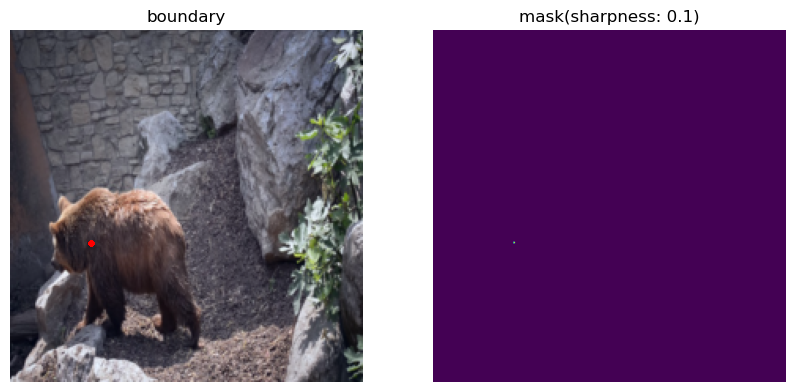

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(
    normalize(
        cur_img[0].permute(1, 2, 0).cpu().detach().numpy(),
    ),
)
plt.axis("off")
# plot the scatter of the boundary
plt.scatter(
    pred_bou[0, :, 0].cpu().detach().numpy(),
    pred_bou[0, :, 1].cpu().detach().numpy(),
    c="r",
    s=10,
)
# plt.plot(
#     pred_bou[0, :, 0].cpu().detach().numpy(),
#     pred_bou[0, :, 1].cpu().detach().numpy(),
#     c="r",
#     # s=10,
# )
plt.title("boundary")
plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0].cpu().detach().numpy())
plt.axis("off")
plt.title(f"mask(sharpness: {sharpness})")
plt.show()

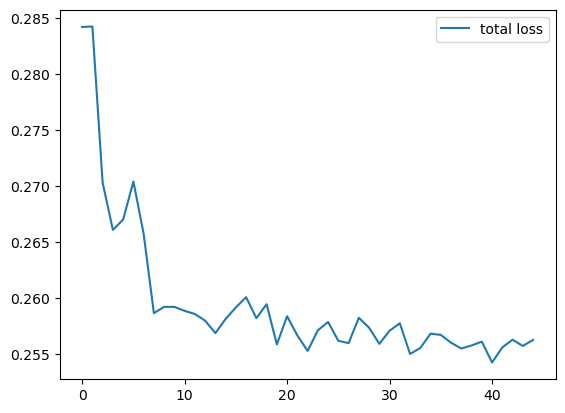

In [36]:
# plot the loss
plt.plot(list(train_total_loss_dict.keys()), list(train_total_loss_dict.values()), label="total loss")

plt.legend()

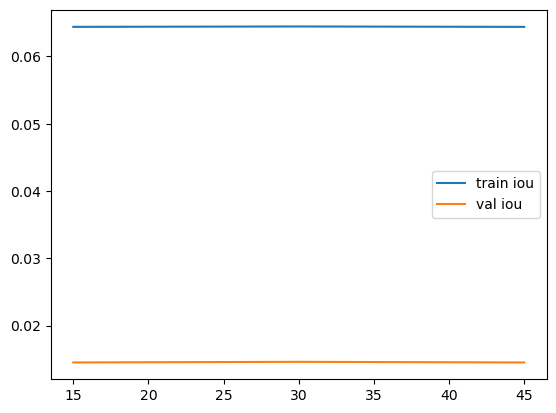

In [37]:
# plot the iou
plt.plot(list(train_iou_dict.keys()), list(train_iou_dict.values()), label="train iou")
plt.plot(list(val_iou_dict.keys()), list(val_iou_dict.values()), label="val iou")
plt.legend()

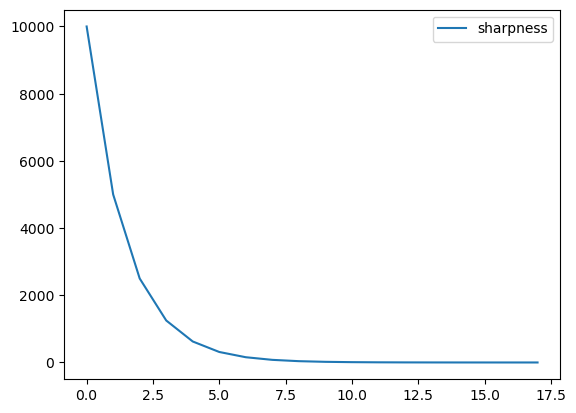

In [38]:
# plot the sharpness
plt.plot(list(sharpness_dict.keys()), list(sharpness_dict.values()), label="sharpness")
plt.legend()

In [65]:
tmp_model = DinoDetrMaskMul(mul_before=True, nhead=1, num_layers=6).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [66]:
tmp_pred_bou = tmp_model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
tmp_pred_bou.shape

torch.Size([4, 80, 2])

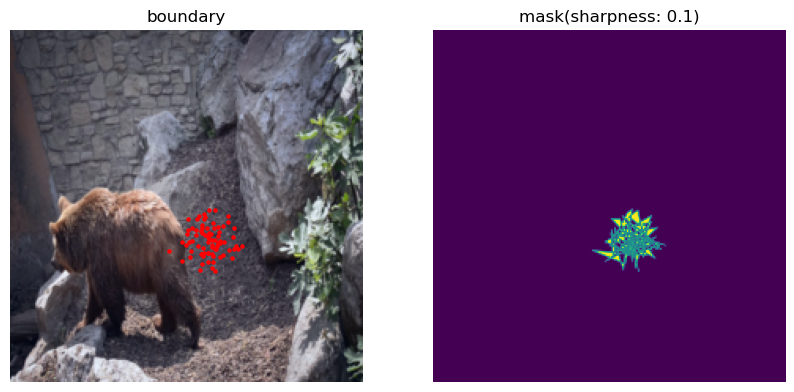

In [67]:
tmp_pred_mask = soft_polygon(tmp_pred_bou, 224, 224)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(
    normalize(
        cur_img[0].permute(1, 2, 0).cpu().detach().numpy(),
    ),
)
plt.axis("off")
# plt.plot(
#     pred_bou[0, :, 0].cpu().detach().numpy(),
#     pred_bou[0, :, 1].cpu().detach().numpy(),
#     "r",
#     linewidth=20,
# )
plt.scatter(
    tmp_pred_bou[0, :, 0].cpu().detach().numpy(),
    tmp_pred_bou[0, :, 1].cpu().detach().numpy(),
    c="r",
    s=5,
)
plt.title("boundary")
plt.subplot(1, 2, 2)
plt.imshow(tmp_pred_mask[0].cpu().detach().numpy())
plt.axis("off")
plt.title(f"mask(sharpness: {sharpness})")
plt.show()

In [213]:
sharpness = 1000.0
ras_loss = RasLoss(inv_smoothness=sharpness).cuda()

In [214]:
for interval in range(interval_steps):
    for e in range(interval_epochs):
        model.train()
        mean_total_loss = 0
        mean_dif_loss = 0
        mean_std_loss = 0
        mean_len_loss = 0
        for (
            video_idx,
            frame_idx,
            fir_img,
            fir_sgm,
            pre_img,
            pre_sgm,
            cur_img,
            cur_sgm,
        ) in tqdm(train_loader):
            optimizer.zero_grad()
            fir_img = fir_img.cuda()
            fir_sgm = fir_sgm.cuda()
            pre_img = pre_img.cuda()
            pre_sgm = pre_sgm.cuda()
            cur_img = cur_img.cuda()
            cur_sgm = cur_sgm.cuda()
            pred_bou = model(fir_img, fir_sgm, pre_img, pre_sgm, cur_img)
            dif_loss = ras_loss(pred_bou, cur_sgm)
            std_loss = deviation_loss(pred_bou)
            len_loss = total_len_loss(pred_bou)
            if std_loss < 0.01:
                loss = 0.33 * dif_loss + 0.33 * len_loss
            else:
                loss = 0.33 * dif_loss + 0.33 * std_loss + 0.33 * len_loss
            loss.backward()
            optimizer.step()
            mean_total_loss += loss.item()
            mean_dif_loss += dif_loss.item()
            mean_std_loss += std_loss.item()
            mean_len_loss += len_loss.item()
        mean_total_loss /= len(train_loader)
        mean_dif_loss /= len(train_loader)
        mean_std_loss /= len(train_loader)
        mean_len_loss /= len(train_loader)
        train_total_loss_dict[epoch_index] = mean_total_loss
        train_dif_loss_dict[epoch_index] = mean_dif_loss
        train_std_loss_dict[epoch_index] = mean_std_loss
        train_len_loss_dict[epoch_index] = mean_len_loss
        print(f"Epoch {epoch_index}, Dif Loss: {mean_dif_loss}")
        print(f"Epoch {epoch_index}, Std Loss: {mean_std_loss}")
        print(f"Epoch {epoch_index}, Len Loss: {mean_len_loss}")
        print(f"Epoch {epoch_index}, total Loss: {mean_total_loss}")
        epoch_index += 1
        if epoch_index % 30 == 0 and sharpness > 0.1:
            sharpness = sharpness / 2
            ras_loss = RasLoss(inv_smoothness=sharpness).cuda()
            # optimizer = optim.Adam(new_model.parameters(), lr=1e-4)
            sharpness_dict[epoch_index] = sharpness
            print(f"Epoch {epoch_index}, sharpness: {sharpness}")
        if sharpness < 0.1:
            sharpness = 0.1
            ras_loss = RasLoss(inv_smoothness=sharpness).cuda()
            sharpness_dict[epoch_index] = sharpness
            print(f"Epoch {epoch_index}, sharpness: {sharpness}")
    train_infer.infer_model(model)
    train_iou = train_infer.get_total_iou()
    train_iou_dict[epoch_index] = train_iou
    val_infer.infer_model(model)
    val_iou = val_infer.get_total_iou()
    val_iou_dict[epoch_index] = val_iou
    print(f"Epoch {epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 14.14it/s]


Epoch 25, Dif Loss: 0.9995752349132445
Epoch 25, Std Loss: 1.972959877293317e-07
Epoch 25, Len Loss: 3.692968121180368e-07
Epoch 25, total Loss: 0.3298599594976844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 14.16it/s]


Epoch 26, Dif Loss: 0.9995635180938535
Epoch 26, Std Loss: 1.982272849323724e-07
Epoch 26, Len Loss: 3.701629854797985e-07
Epoch 26, total Loss: 0.3298560924646331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:14<00:00, 14.16it/s]


Epoch 27, Dif Loss: 0.9995879304118273
Epoch 27, Std Loss: 1.9799297393358468e-07
Epoch 27, Len Loss: 3.690765831057744e-07
Epoch 27, total Loss: 0.3298641486865718


 29%|████████████████████████████████████████▌                                                                                                    | 59/205 [00:04<00:10, 14.13it/s]


KeyboardInterrupt: 

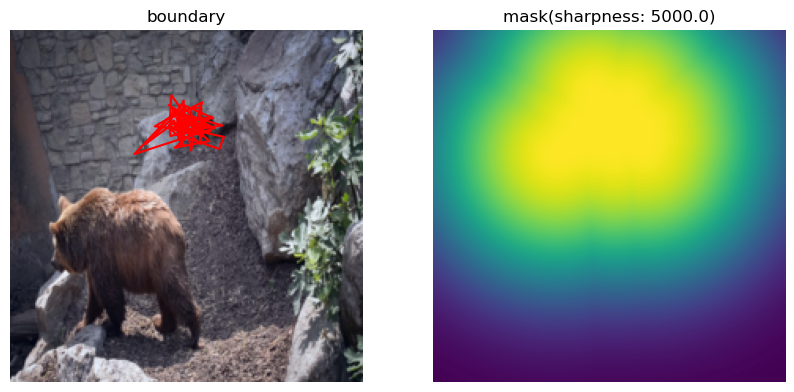

In [192]:
(
    video_idx,
    frame_idx,
    fir_img,
    fir_sgm,
    pre_img,
    pre_sgm,
    cur_img,
    cur_sgm,
) = next(iter(unshuffle_train_loader))
pred_bou = new_model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)
soft_polygon = SoftPolygon(inv_smoothness=sharpness)
pred_mask = soft_polygon(pred_bou, 224, 224)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(
    normalize(
        cur_img[0].permute(1, 2, 0).cpu().detach().numpy(),
    ),
)
plt.axis("off")
# plot the scatter of the boundary
plt.plot(
    pred_bou[0, :, 0].cpu().detach().numpy(),
    pred_bou[0, :, 1].cpu().detach().numpy(),
    c="r",
    # s=10,
)
plt.title("boundary")
plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0].cpu().detach().numpy())
plt.axis("off")
plt.title(f"mask(sharpness: {sharpness})")
plt.show()

In [61]:
ras_loss = RasLoss(inv_smoothness=1.0).cuda()

In [62]:
for interval in range(interval_steps):
    for e in range(interval_epochs):
        model.train()
        mean_total_loss = 0
        mean_dif_loss = 0
        mean_std_loss = 0
        mean_len_loss = 0
        for (
            video_idx,
            frame_idx,
            fir_img,
            fir_sgm,
            pre_img,
            pre_sgm,
            cur_img,
            cur_sgm,
        ) in tqdm(train_loader):
            optimizer.zero_grad()
            fir_img = fir_img.cuda()
            fir_sgm = fir_sgm.cuda()
            pre_img = pre_img.cuda()
            pre_sgm = pre_sgm.cuda()
            cur_img = cur_img.cuda()
            cur_sgm = cur_sgm.cuda()
            pred_bou = model(fir_img, fir_sgm, pre_img, pre_sgm, cur_img)
            dif_loss = ras_loss(pred_bou, cur_sgm)
            std_loss = deviation_loss(pred_bou)
            len_loss = total_len_loss(pred_bou)
            if std_loss < 0.01:
                std_loss = torch.tensor(0.00).cuda()
            loss = 0.33 * dif_loss + 0.33 * std_loss + 0.33 * len_loss
            loss.backward()
            optimizer.step()
            mean_total_loss += loss.item()
            mean_dif_loss += dif_loss.item()
            mean_std_loss += std_loss.item()
            mean_len_loss += len_loss.item()
        mean_total_loss /= len(train_loader)
        mean_dif_loss /= len(train_loader)
        mean_std_loss /= len(train_loader)
        mean_len_loss /= len(train_loader)
        train_total_loss_dict[epoch_index] = mean_total_loss
        train_dif_loss_dict[epoch_index] = mean_dif_loss
        train_std_loss_dict[epoch_index] = mean_std_loss
        train_len_loss_dict[epoch_index] = mean_len_loss
        print(f"Epoch {epoch_index}, Dif Loss: {mean_dif_loss}")
        print(f"Epoch {epoch_index}, Std Loss: {mean_std_loss}")
        print(f"Epoch {epoch_index}, Len Loss: {mean_len_loss}")
        print(f"Epoch {epoch_index}, total Loss: {mean_total_loss}")
        epoch_index += 1
    train_infer.infer_model(model)
    train_iou = train_infer.get_total_iou()
    train_iou_dict[epoch_index] = train_iou
    val_infer.infer_model(model)
    val_iou = val_infer.get_total_iou()
    val_iou_dict[epoch_index] = val_iou
    print(f"Epoch {epoch_index}, Train IoU: {train_iou}, Val IoU: {val_iou}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  2.97it/s]


Epoch 18, Dif Loss: 0.6260424541264046
Epoch 18, Std Loss: 0.05663068476700928
Epoch 18, Len Loss: 0.08659305235189273
Epoch 18, total Loss: 0.2538578532817887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 19, Dif Loss: 0.6234592138267145
Epoch 19, Std Loss: 0.05517114646187643
Epoch 19, Len Loss: 0.08483258766326598
Epoch 19, total Loss: 0.25194278293993416


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 20, Dif Loss: 0.6453565388191037
Epoch 20, Std Loss: 0.050617456481587594
Epoch 20, Len Loss: 0.07560849447348496
Epoch 20, total Loss: 0.25462223124213335
Epoch 21, Train IoU: 0.06453663399124301, Val IoU: 0.014594232111337277


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.01it/s]


Epoch 21, Dif Loss: 0.6462329341144096
Epoch 21, Std Loss: 0.05045084668459689
Epoch 21, Len Loss: 0.07772262281760937
Epoch 21, total Loss: 0.2555541224595977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 22, Dif Loss: 0.6165409218974229
Epoch 22, Std Loss: 0.05474554005010826
Epoch 22, Len Loss: 0.08365029583730531
Epoch 22, total Loss: 0.24912914044973328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 23, Dif Loss: 0.6338170609823087
Epoch 23, Std Loss: 0.050628406272792234
Epoch 23, Len Loss: 0.07794119084776356
Epoch 23, total Loss: 0.25158760765703714
Epoch 24, Train IoU: 0.0645423645652367, Val IoU: 0.014586294424933144


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 24, Dif Loss: 0.6129395601226062
Epoch 24, Std Loss: 0.05066250451363442
Epoch 24, Len Loss: 0.0776114070504086
Epoch 24, total Loss: 0.24460045586271983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 25, Dif Loss: 0.6105743562302939
Epoch 25, Std Loss: 0.051732242607125424
Epoch 25, Len Loss: 0.07959720310755074
Epoch 25, total Loss: 0.24482826568731447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:08<00:00,  3.00it/s]


Epoch 26, Dif Loss: 0.6173519907928094
Epoch 26, Std Loss: 0.050811741482920766
Epoch 26, Len Loss: 0.0776824312727535
Epoch 26, total Loss: 0.2461292441298322
Epoch 27, Train IoU: 0.0645486708558506, Val IoU: 0.014606949262684077
